**Downloading the dataset from kaggle**

In [122]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/online-retail-ii-uci


In [123]:
!mv "/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3" "/content/data"

mv: cannot stat '/root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3': No such file or directory


**Importing the pandas & matplotlib for data cleaning & data visualization**

In [124]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [125]:
data_path = "/content/data/online_retail_II.csv"

data_df = pd.read_csv(data_path, encoding="ISO-8859-1", dtype={'Customer ID': str})
data_df.shape

(1067371, 8)

In [126]:
data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [127]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   object 
 7   Country      1067371 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 65.1+ MB


From the information we know about this dataset, the "Price" column represents the "UnitPrice" and that's why we have a quantity column.

Let's rename this column to the "UnitPrice"

In [128]:
data_df.rename(columns={"Price":"UnitPrice", "Customer ID":"CustomerID"}, inplace=True)

In [129]:
data_df['CustomerID'] = data_df['CustomerID'].str.split(pat='.', expand=True)[0]

In [130]:
# The time part in the InvoiceDate isn't neccesary for our analysis so let's remove it.
data_df['InvoiceDate'] = data_df['InvoiceDate'].str.split(pat=' ', expand=True)[0]

data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085,United Kingdom


Let's change date column's type to datetime.

In [131]:
data_df['InvoiceDate'] = pd.to_datetime(data_df['InvoiceDate'])

data_df['InvoiceDate'].info()
data_df['InvoiceDate'].head()

<class 'pandas.core.series.Series'>
RangeIndex: 1067371 entries, 0 to 1067370
Series name: InvoiceDate
Non-Null Count    Dtype         
--------------    -----         
1067371 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 8.1 MB


,InvoiceDate
0,2009-12-01
1,2009-12-01
2,2009-12-01
3,2009-12-01
4,2009-12-01


Every column have 1067371 non-null value except for the Description and the **CustomerID** columns.


Since our goal isn't **customer-based**, but more focused on attributes like **demand, total revenue, & most sold products**, we'll add **"Guest"** for each null value in the **"CustomerID"** column.

Having nulls in the **"Description"** column doesn't matter as long as we have a **"StockCode"** value which uniquely identifies each product.

In [132]:
data_df["CustomerID"].fillna("Guest", inplace=True)

data_df.info()

<ipython-input-132-f454fa03fc85>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df["CustomerID"].fillna("Guest", inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   UnitPrice    1067371 non-null  float64       
 6   CustomerID   1067371 non-null  object        
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 65.1+ MB


In [133]:
# Check out how many duplicate rows we have
data_df.duplicated().value_counts()

,count
False,1033034
True,34337


In [134]:
data_df = data_df.drop_duplicates()
data_df.shape

(1033034, 8)

In [135]:
# Check if Quantity or UnitPrice have negative values
invalid_quantities = data_df["Quantity"][data_df["Quantity"] < 1].head()

invalid_price = data_df["UnitPrice"][data_df["UnitPrice"] < 0].head()

print(f"Invalid Quantity values: \n{invalid_quantities}\n\nInvalid UnitPrice values: \n{invalid_price}")

Invalid Quantity values: 
178   -12
179    -6
180    -4
181    -6
182   -12
Name: Quantity, dtype: int64

Invalid UnitPrice values: 
179403   -53594.36
276274   -44031.79
403472   -38925.87
825444   -11062.06
825445   -11062.06
Name: UnitPrice, dtype: float64


In [136]:
# Check if Quantity or UnitPrice have negative values
invalid_quantities = data_df["Quantity"][data_df["Quantity"] < 1].count()

# In case this syntax doesn't make sense:
# It's seriesObj[condition].value_counts()
# Here, the seriesObj is data_df["Quantity"] & the condition is [data_df["Quantity"] < 1]

invalid_price = data_df["UnitPrice"][data_df["UnitPrice"] < 0].count()

print(f"Invalid Quantity values: {invalid_quantities}\nInvalid UnitPrice values: {invalid_price}")

Invalid Quantity values: 22496
Invalid UnitPrice values: 5


**There're 2 situations that can lead to different modification for this data:**
1. These negative values are just a data-entry human error and they're supposed to be positive. In this case, we can just invert any negative sign back to positive.
2. These negative values represent refunds which is less probable. In this case we should use them as they are.
3. These values are just a very small segment of the data and dropping them won't affect the dataset so hard.

In this approach, we're simply dropping them.

In [137]:
# Drop invalid quantities & UnitPrices
data_df = data_df[(data_df["Quantity"] >= 1) & (data_df["UnitPrice"] > 0)]

# If this line returns false, then the filteration went successfully.
data_df["Quantity"][data_df["Quantity"] < 1].any()

np.False_

In [138]:
# Remove cancelled orders (invoices starting with 'C')
data_df = data_df[~data_df['Invoice'].str.contains('C', na=False)]

In [139]:
data_df.shape

(1007911, 8)

**Further Exploration for the dataset**

In [140]:
# Unique countries

# normalize => If True then the object returned will contain the relative frequencies
# of the unique values.
uq_countries = data_df["Country"].value_counts(
    normalize=True,
    ascending=False)

uq_countries

,proportion
Country,
United Kingdom,0.918768
EIRE,0.017019
Germany,0.016303
France,0.013532
Netherlands,0.005045
Spain,0.003633
Switzerland,0.003097
Belgium,0.003031
Portugal,0.002451


We are keeping countries with low contribution to the data because regardless the volume of their contribution, they still affect the revenue for the marketplace and our goal is demand and revenue driven.

In [141]:
# Now, let's get the revenue coming from each country
data_df["Revenue"] = (data_df["Quantity"] * data_df["UnitPrice"]).round(2)

country_revenue = data_df.groupby('Country')['Revenue'].sum().sort_values(
    ascending=False
    )
country_revenue

<ipython-input-141-97ef900f484b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["Revenue"] = (data_df["Quantity"] * data_df["UnitPrice"]).round(2)


,Revenue
Country,
United Kingdom,17410162.50
EIRE,658767.31
Netherlands,554038.09
Germany,425019.71
France,350456.09
Australia,169283.46
Spain,108332.49
Switzerland,100685.59
Sweden,91869.82


In [142]:
# Add a "isGuest" column with boolean values:

data_df["isGuest"] = data_df["CustomerID"] == "Guest"

In [143]:
data_df["isGuest"].value_counts()

,count
isGuest,
False,779423
True,228488


So we have 132186 customers (about third of the data) with no customerID. We are still going to use them in our analysis because their percent relative to the whole data is so large and our analysis isn't customer-driven.

# **Data Cleaning Conclusion**
The dataset was cleaned by handling missing values, removing duplicates, and eliminating invalid transactions.

Missing CustomerID values were filled with "Guest", and duplicate rows were dropped.

Transactions with negative Quantity or UnitPrice less than 1 were removed.

A Revenue column was added.

A IsGuest column was also created to differentiate guest purchases.

After final checks, the dataset is now clean, structured, and ready for analysis, including customer insights, trend identification, and predictive modeling.

In [144]:
# Let's have another look to our data before starting data visulization:
print(data_df.head())
data_df.info()
print(data_df.shape)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

  InvoiceDate  UnitPrice CustomerID         Country  Revenue  isGuest  
0  2009-12-01       6.95      13085  United Kingdom     83.4    False  
1  2009-12-01       6.75      13085  United Kingdom     81.0    False  
2  2009-12-01       6.75      13085  United Kingdom     81.0    False  
3  2009-12-01       2.10      13085  United Kingdom    100.8    False  
4  2009-12-01       1.25      13085  United Kingdom     30.0    False  
<class 'pandas.core.frame.DataFrame'>
Index: 1007911 entries, 0 to 1067370
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dty

In [145]:
data_df.to_csv("/content/data/clean_dataset.csv", index=False)

**Sales Trends Over Time**

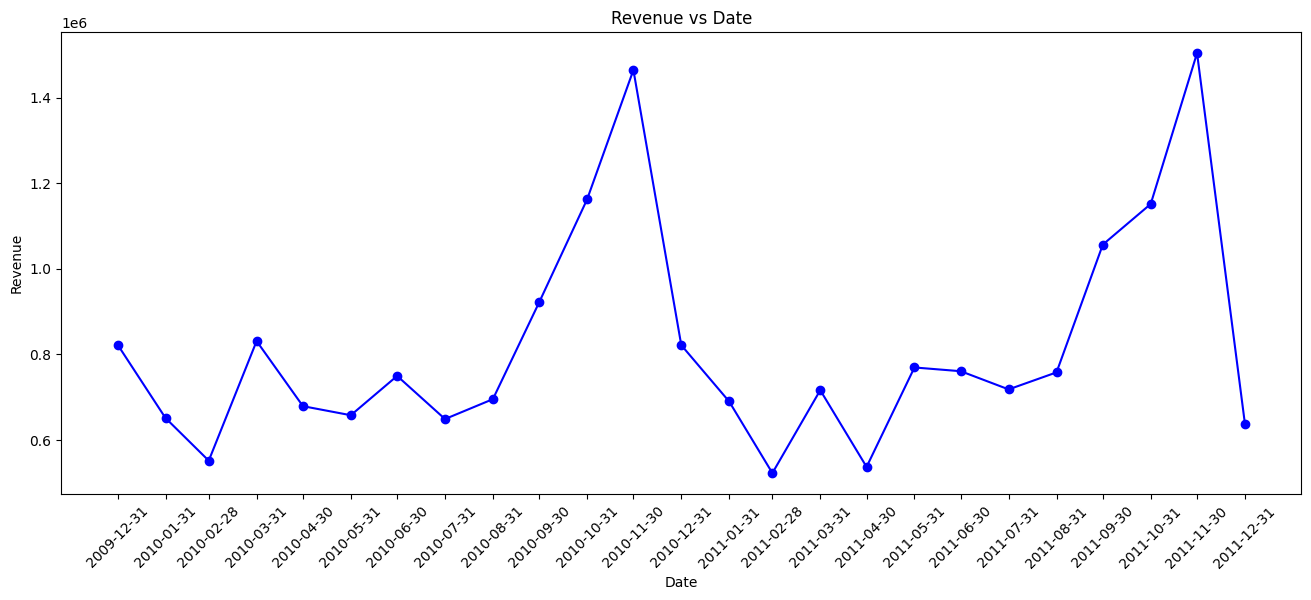

In [146]:
# A line chart of Revenue vs Date
monthly_revenue = data_df.resample('1ME', on='InvoiceDate')["Revenue"].sum()

plt.figure(figsize=(16, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, linestyle='-', marker ='o', color='blue')

plt.title("Revenue vs Date")

plt.xlabel("Date")
plt.ylabel("Revenue")
# plt.figure(figsize=(10, 10)) ==> This line is useless, I have to replace it before calling plt.plot()

# Force every date to appear on the x-axis
plt.xticks(ticks=monthly_revenue.index, labels=monthly_revenue.index.strftime('%Y-%m-%d'), rotation=45)

plt.show();



# Time-series analysis.
# df.resample()
# plt.xticks()

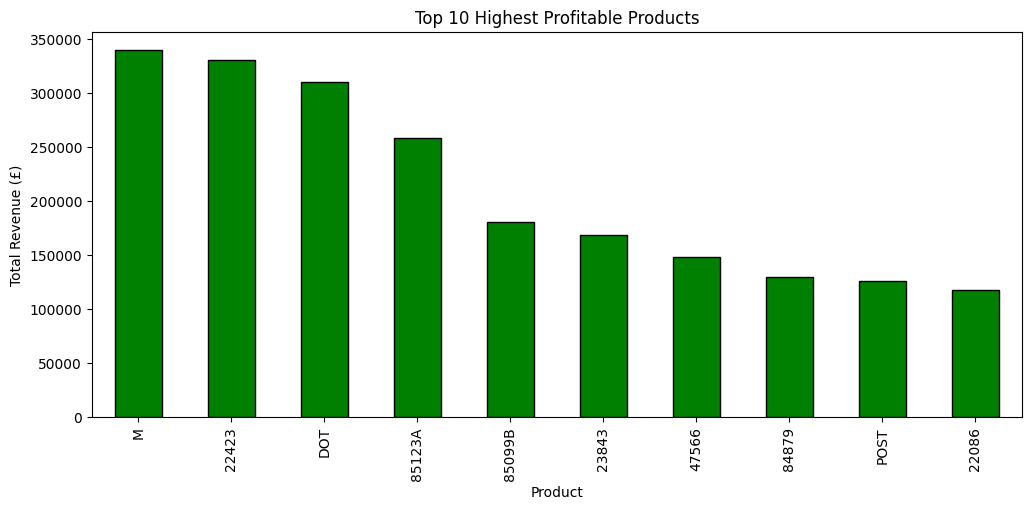

In [147]:
# Top Profitable Items: (StockCode vs Total_Revenue)
top_products = data_df.groupby("StockCode")["Revenue"].sum().sort_values(ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12,5))
top_products.plot(kind="bar", color="green", edgecolor="black")

# Labels and title
plt.xlabel("Product")
plt.ylabel("Total Revenue (£)")
plt.title("Top 10 Highest Profitable Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

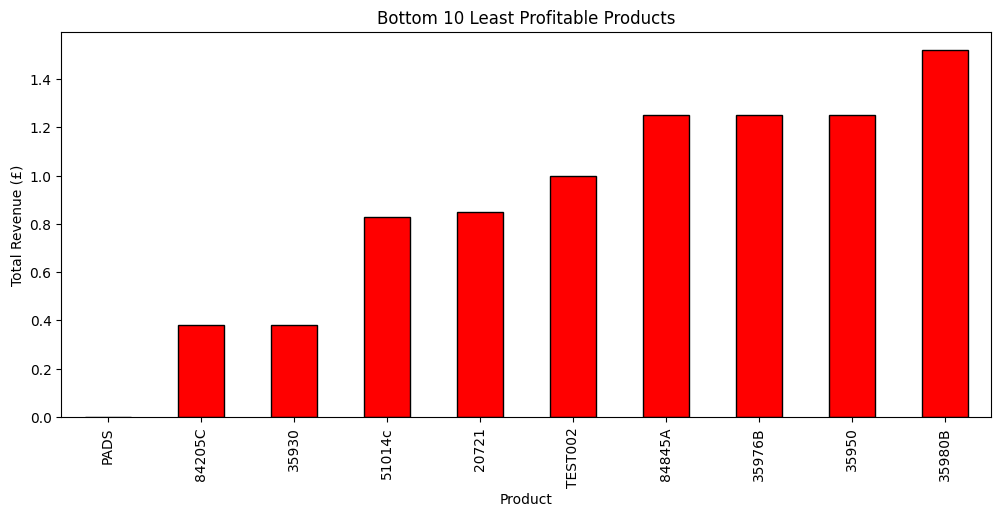

In [148]:
# Least Profitable Items:
worst_products = data_df.groupby("StockCode")["Revenue"].sum().sort_values(ascending=True).head(10)

plt.figure(figsize=(12,5))
worst_products.plot(kind="bar", color="red", edgecolor="black")

plt.xlabel("Product")
plt.ylabel("Total Revenue (£)")
plt.title("Bottom 10 Least Profitable Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()
# These low-revenue products might need discounts, better marketing, or discontinuation.
# Could be seasonal (e.g., winter items sell poorly in summer).
# Helps businesses optimize inventory and focus on better-performing products

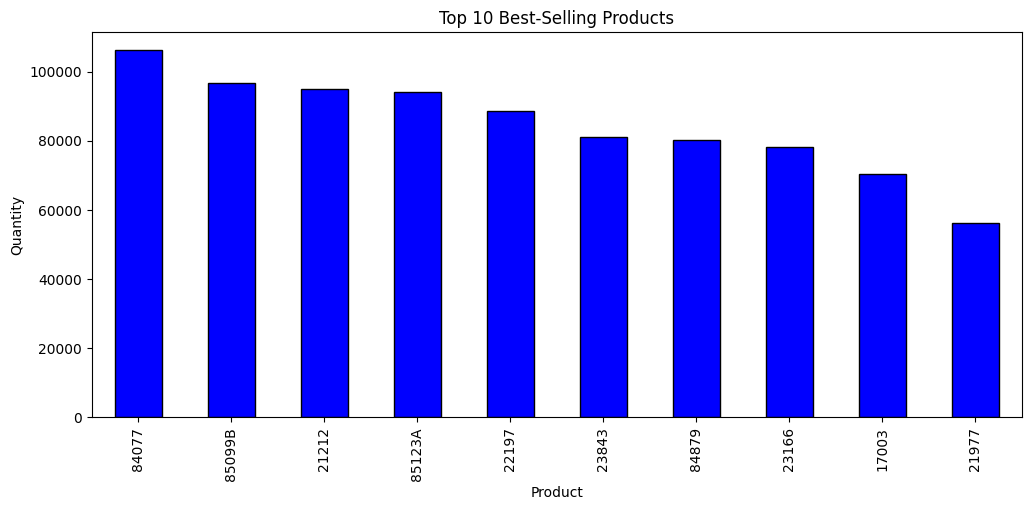

In [149]:
# Best-Selling Items: (StockCode vs Total_Revenue)
best_selling = data_df.groupby("StockCode")["Quantity"].sum().sort_values(ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12,5))
best_selling.plot(kind="bar", color="blue", edgecolor="black")

# Labels and title
plt.xlabel("Product")
plt.ylabel("Quantity")
plt.title("Top 10 Best-Selling Products")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.show()

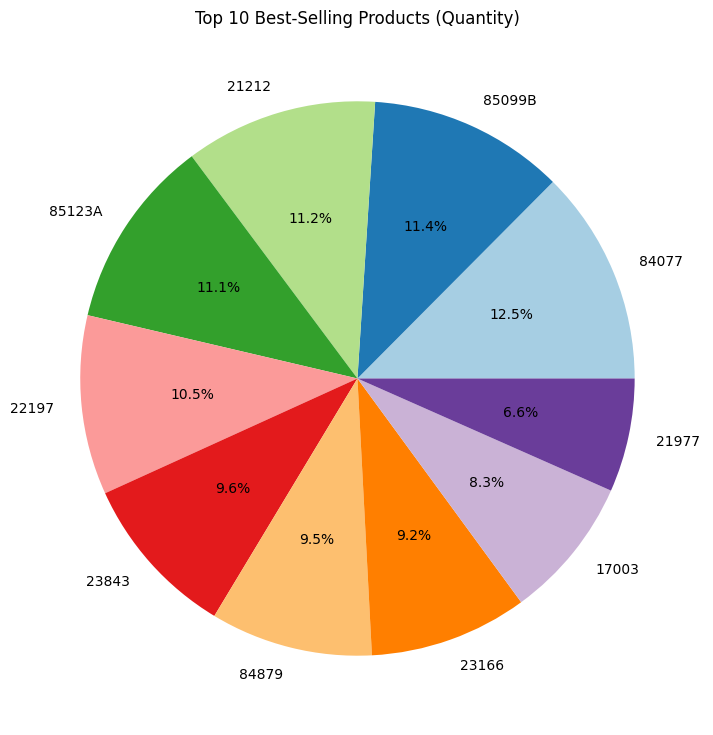

In [150]:
# Calculate total quantity sold per product
top_products = data_df.groupby("StockCode")["Quantity"].sum().nlargest(10)

# Plot Pie Chart
plt.figure(figsize=(12, 9))
plt.pie(top_products, labels=top_products.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title("Top 10 Best-Selling Products (Quantity)")
plt.show()

As we can see, the most sold item isn't the highest profitable one. It's not even in the list of top 10 profitable items.

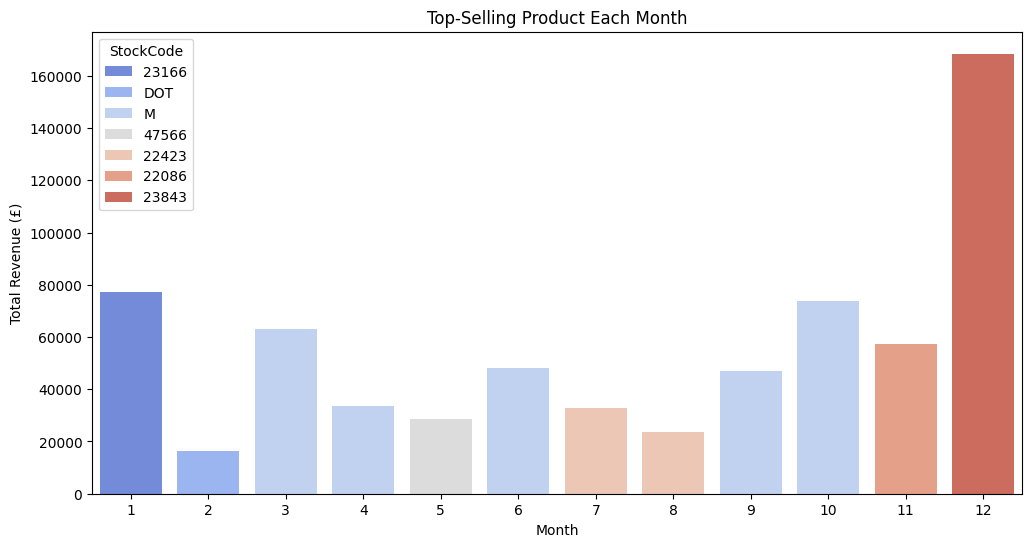

In [151]:
# Top profitable item of each month:
data_df["Month"] = data_df["InvoiceDate"].dt.month

# Group by month and product to find best-selling products each month
monthly_sales = data_df.groupby(["Month", "StockCode"])["Revenue"].sum().reset_index()
top_monthly_products = monthly_sales.loc[monthly_sales.groupby("Month")["Revenue"].idxmax()]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="Month", y="Revenue", hue="StockCode", data=top_monthly_products, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Total Revenue (£)")
plt.title("Top-Selling Product Each Month")

plt.show()

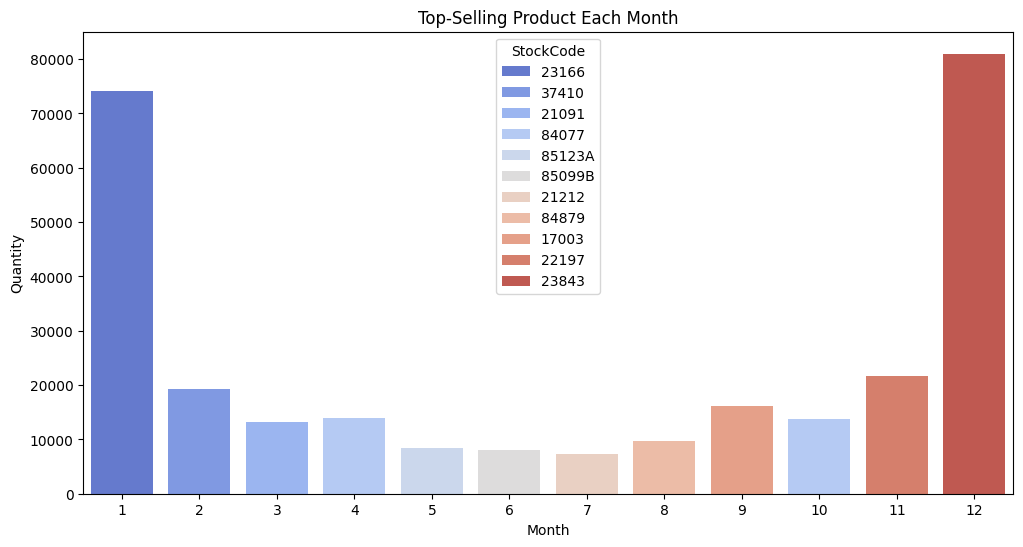

In [152]:
# Top-selling item of each month:
data_df["Month"] = data_df["InvoiceDate"].dt.month

# Group by month and product to find best-selling products each month
monthly_sales = data_df.groupby(["Month", "StockCode"])["Quantity"].sum().reset_index()
top_monthly_products = monthly_sales.loc[monthly_sales.groupby("Month")["Quantity"].idxmax()]

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="Month", y="Quantity", hue="StockCode", data=top_monthly_products, palette="coolwarm")
plt.xlabel("Month")
plt.ylabel("Quantity")
plt.title("Top-Selling Product Each Month")

plt.show()

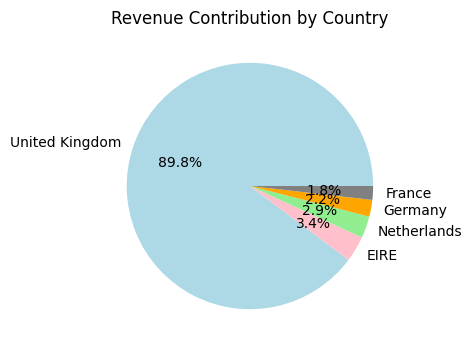

In [153]:
# Top countries involved:
top_countries = data_df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(5)

plt.figure(figsize=(4,4))
plt.pie(top_countries, labels=top_countries.index, autopct="%1.1f%%", colors=["#ADD8E6", "pink", "lightgreen", "orange", "gray"])
plt.title("Revenue Contribution by Country")
plt.show()
#Identifies the top markets for sales.

Does lower unit-price means more sales?

Let's check it out

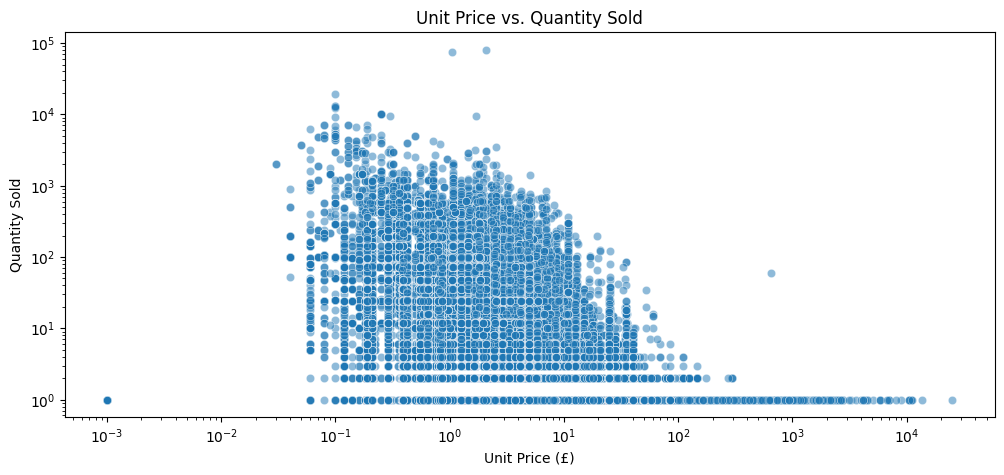

Correlation Coefficient (r): -0.0038554533727891385


In [154]:
# A scatter plot to check the relationship between unit-price and sold quantity
plt.figure(figsize=(12,5))
sns.scatterplot(data=data_df, x="UnitPrice", y="Quantity", alpha=0.5)  # alpha=0.5 for transparency to handle overlapping points.

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Unit Price (£)")
plt.ylabel("Quantity Sold")
plt.title("Unit Price vs. Quantity Sold")
plt.show()
# Checks if low prices lead to higher sales.

r_value = data_df["UnitPrice"].corr(data_df["Quantity"])
print(f"Correlation Coefficient (r): {r_value}")

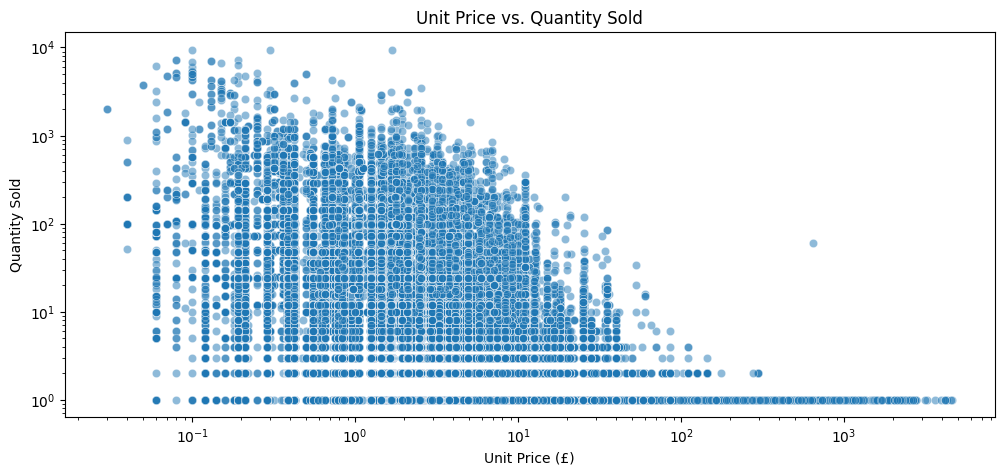

Correlation Coefficient (r): -0.0038554533727891385


In [155]:
# Removing extreme values to get a representative correlation coefficient value
df_filtered = data_df[(data_df["UnitPrice"] < 5000) & (data_df["Quantity"] < 10000) & (data_df["UnitPrice"]>0.001)]

plt.figure(figsize=(12,5))
sns.scatterplot(data=df_filtered, x="UnitPrice", y="Quantity", alpha=0.5)  # alpha=0.5 for transparency to handle overlapping points.

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Unit Price (£)")
plt.ylabel("Quantity Sold")
plt.title("Unit Price vs. Quantity Sold")
plt.show()
# Checks if low prices lead to higher sales.

r_value = data_df["UnitPrice"].corr(data_df["Quantity"])
print(f"Correlation Coefficient (r): {r_value}")

So it's almost the same value which is an extremely minimal, negligible inverse relationship.

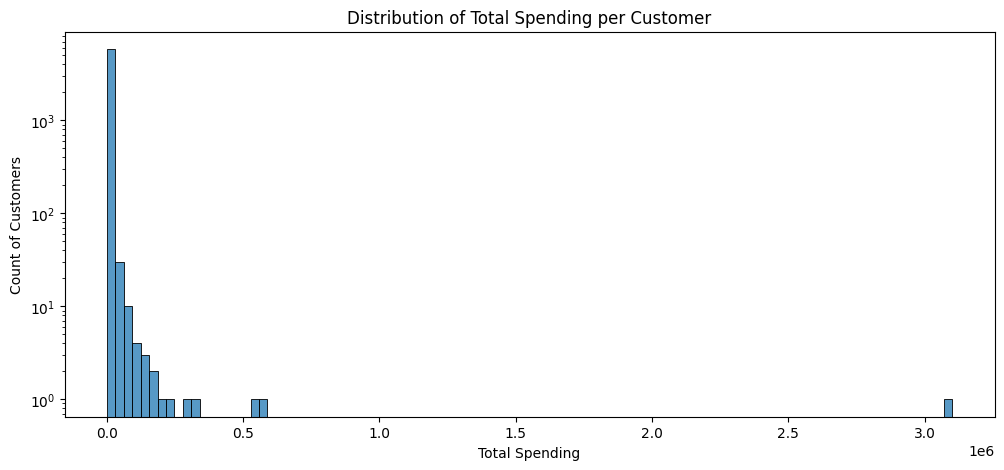

In [156]:
# Top customers
plt.figure(figsize=(12, 5))

customer_purchases = data_df.groupby("CustomerID")["Revenue"].sum()

# Plot the distribution
sns.histplot(customer_purchases, bins=100, kde=False)

plt.xlabel("Total Spending")
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.title("Distribution of Total Spending per Customer")
plt.show()

Number of removed customers before replotting: 1


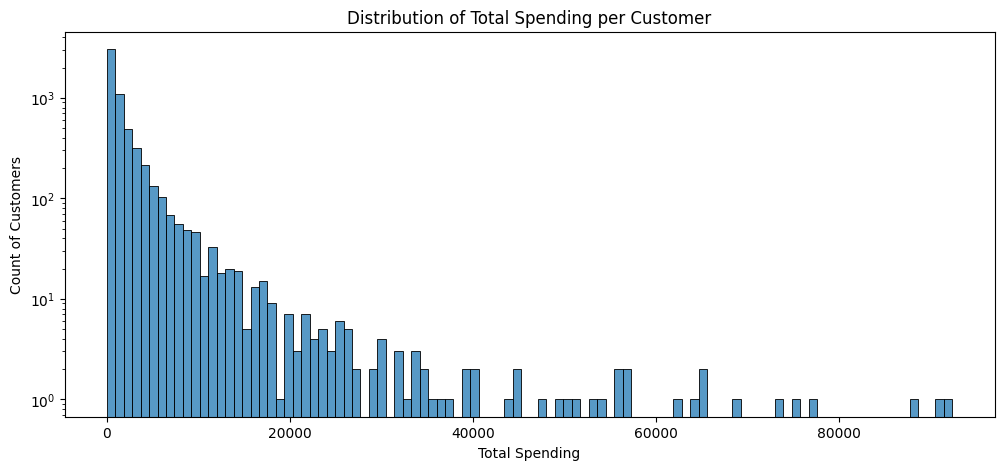

In [157]:
# After removing the customers that spent more than 3 Million:
print(f"Number of removed customers before replotting: {customer_purchases[customer_purchases > 3_000_000].size}")

filtered_purchases = customer_purchases[customer_purchases < 1_00_000]

plt.figure(figsize=(12, 5))
sns.histplot(filtered_purchases, bins=100, kde=False)

plt.xlabel("Total Spending")
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.title("Distribution of Total Spending per Customer")
plt.show()

# Note how this graph is more clean and representative

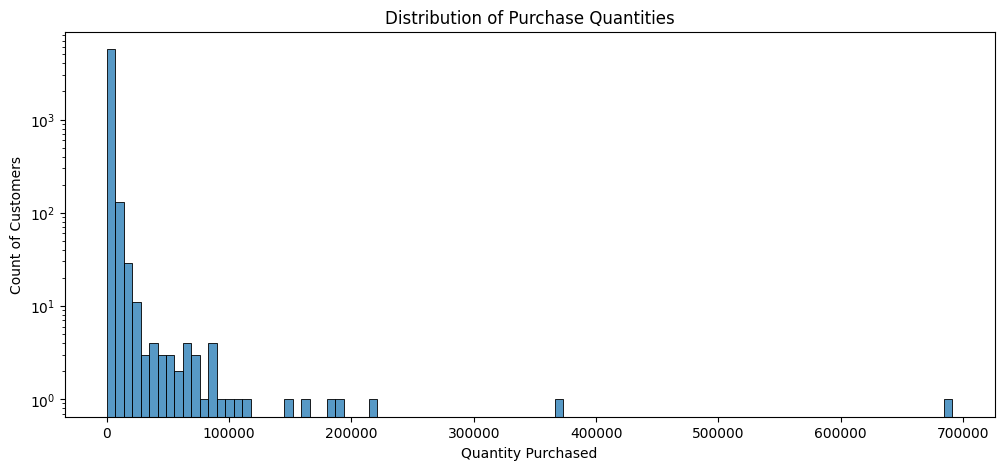

In [158]:
# Customers that bought the most amount of items:
customer_purchases_amnt = data_df.groupby("CustomerID")["Quantity"].sum()

plt.figure(figsize=(12, 5))
# Plot the distribution
sns.histplot(customer_purchases_amnt, bins=100, kde=False)
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.xlabel("Quantity Purchased")
plt.title("Distribution of Purchase Quantities")
plt.show()

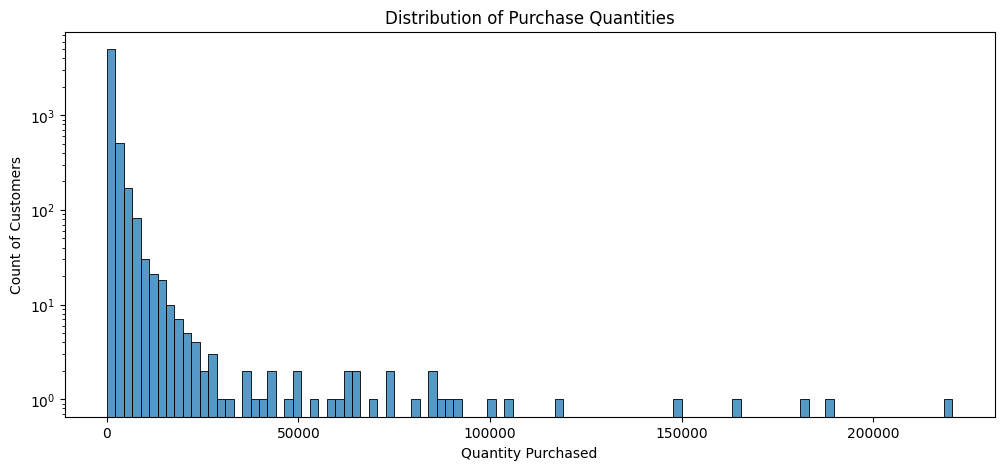

In [159]:
# After removing quantities more than 300k items (only 2 customers removed)
filtered_purchases_amnt = customer_purchases_amnt[customer_purchases_amnt < 3_00_000]

plt.figure(figsize=(12, 5))
# Plot the distribution
sns.histplot(filtered_purchases_amnt, bins=100, kde=False)
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Count of Customers")
plt.xlabel("Quantity Purchased")
plt.title("Distribution of Purchase Quantities")
plt.show()

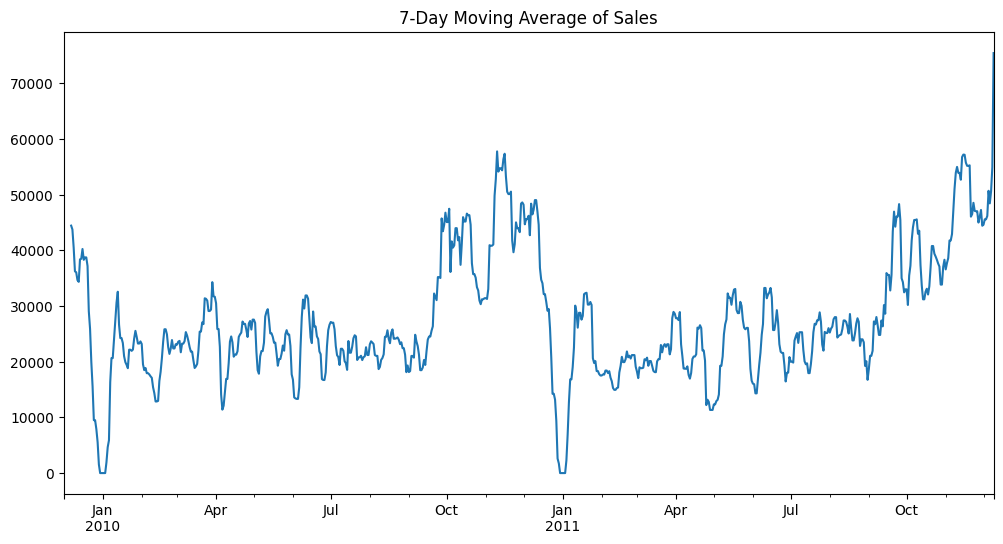

In [160]:
# Moving Average

# Group by date and sum Revenue for each day
daily_sales = data_df.groupby("InvoiceDate")["Revenue"].sum()

# Reindex to include all dates between min and max, filling missing days with 0 sales
daily_sales = daily_sales.reindex(pd.date_range(start=daily_sales.index.min(),
                                                end=daily_sales.index.max(),
                                                freq='D'), fill_value=0)

daily_sales.rolling(window=7).mean().plot(figsize=(12, 6), title="7-Day Moving Average of Sales")
plt.show()

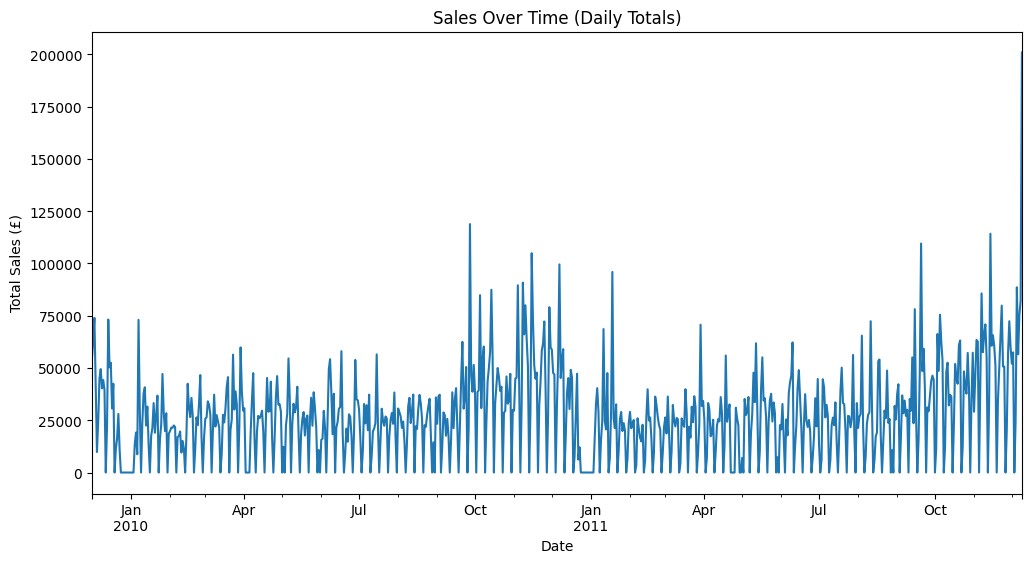

In [161]:
# Seasonal Trend Analysis:
daily_sales.plot(figsize=(12, 6), title="Sales Over Time (Daily Totals)")
plt.xlabel("Date")
plt.ylabel("Total Sales (£)")
plt.show()

# Seasonal Trends Analysis

Decomposes sales data into Trend, Seasonality, and Residuals. Useful for understanding how demand fluctuates over time.

In [162]:
daily_sales.head(100)

,Revenue
2009-12-01,54351.23
2009-12-02,63172.58
2009-12-03,73972.45
2009-12-04,40582.32
2009-12-05,9803.05
...,...
2010-03-06,0.00
2010-03-07,19805.55
2010-03-08,37254.31
2010-03-09,21999.60


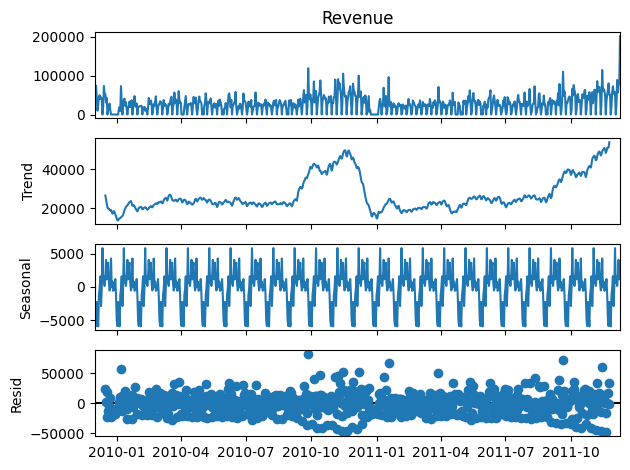

In [163]:
# Decompose daily sales with a 30-day period (adjust as needed)
decomposed = seasonal_decompose(daily_sales, model='additive', period=30)

# Plot decomposition
decomposed.plot()
plt.show()

Let's show which months/days have higher demand.

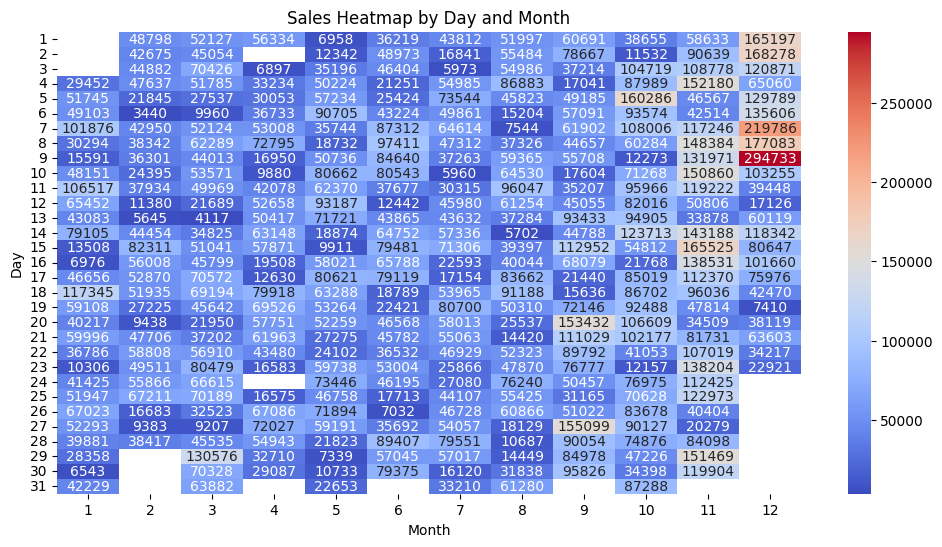

In [164]:
data_df["Day"] = data_df["InvoiceDate"].dt.day
pivot_table = data_df.pivot_table(values='Revenue', index='Day', columns='Month', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".0f")
plt.title("Sales Heatmap by Day and Month")
plt.show()

Feature Correlation Heatmap

Identifies relationships between variables (e.g., promotions, holidays, weather).

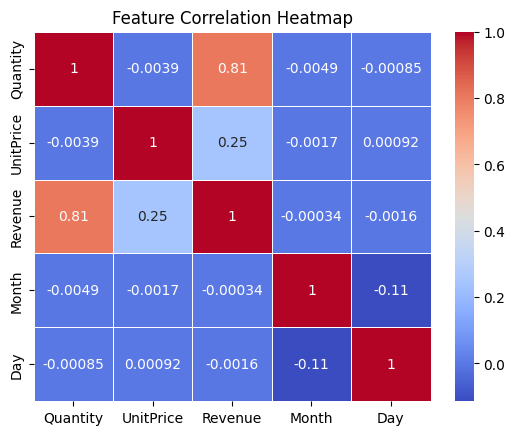

In [165]:
# Calculate correlations only for numeric columns
corr = data_df.select_dtypes(include=['number']).corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Sales Distribution

Helps detect anomalies in sales data.

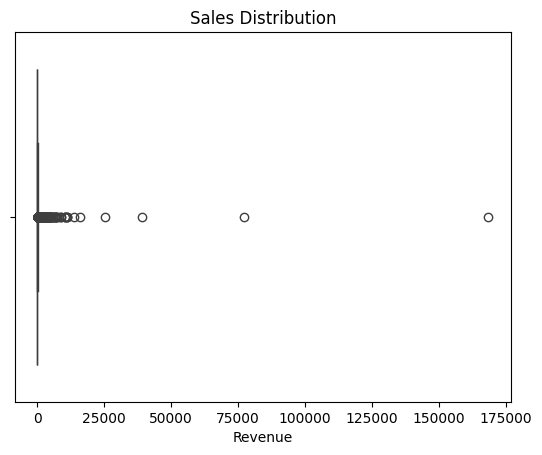

In [166]:
sns.boxplot(x=data_df['Revenue'])
plt.title("Sales Distribution")
plt.show()

# What about outliers?

The current visualization charts show that our dataset still have some outliers.

Because Quantity, UnitPrice, and Revenue are going to be used as features to train our model, we need to handle their outliers. Instead of removing them, we apply Winsorization (capping) to prevent extreme values from skewing the model while retaining all data points for better generalization.

In other words, we will be replacing extreme values with the nearest acceptable value.

In [167]:
# Capping limits:
lower_limit = data_df["Quantity"].quantile(0.05)  # 5th percentile
upper_limit = data_df["Quantity"].quantile(0.95)  # 95th percentile

# Apply Winsorization (Capping)
data_df["Quantity"] = np.where(data_df["Quantity"] > upper_limit, upper_limit, data_df["Quantity"])
data_df["Quantity"] = np.where(data_df["Quantity"] < lower_limit, lower_limit, data_df["Quantity"])

In [168]:
data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,isGuest,Month,Day
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01,6.95,13085,United Kingdom,83.4,False,12,1
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",31.0,2009-12-01,2.10,13085,United Kingdom,100.8,False,12,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01,1.25,13085,United Kingdom,30.0,False,12,1


Creating products categories for easier demand prediction

In [171]:
print(data_df["Description"].unique())

['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... 'SET 10 CARDS SWIRLY XMAS TREE 17104'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']


In [172]:
np.savetxt("/content/products_description.csv", data_df["Description"].unique(), delimiter=",", fmt='%s')

In [178]:
# Category Dictionary:
CATEGORY_KEYWORDS = {
    'Seasonal': ['christmas', 'xmas', 'easter', 'santa', 'snowflake', 'reindeer', 'egg', 'advent', 'village', 'snowmen', 'toadstool', 'cacti', 'halloween', 'decoupage', 'ribbon', 'flock', 'stocking', 'bauble', 'bunny', 'chick', 'tree decoration', 'easter hen', 'christmas ball', 'jingle bell', 'tinsel', 'ornament', 'felt decoration', 'garland stars', 'bauble set', 'icicle lights', 'craft decoration', 'paper chain'],
    'Home Decor': ['knob', 't-light', 'holder', 'wicker', 'mirror', 'wall art', 'heart', 'frame', 'wreath', 'clock', 'cushion', 'doily', 'doiley', 'vase', 'shelf', 'tile', 'hook', 'planter', 'chandelier', 'curio', 'photo frame', 'trellis', 'antique', 'vintage', 'parisienne', 'edwardian', 'chalkboard', 'coaster', 'placemat', 'candlestick', 'stand', 'cornice', 'cloche', 'frieze', 'quilt', 'trinket tray', 'photo clip', 'lattice', 'shelf unit', 'sign', 'garland', 'curtain', 'plaque', 'mirror ball', 'doormat', 'wall mirror', 'votive holder', 'candlestick candle', 'candlepot', 'photo holder', 'wall plaque', 'pillow filler', 'decorative tray', 'wall shelf', 'ornamental frame', 'word block', 'diner clock', 'decorative hook', 'record frame'],
    'Kitchenware': ['jug', 'pantry', 'chopping board', 'spoon', 'mug', 'plate', 'enamel', 'bowl', 'tray', 'jampot', 'thermo', 'utensil', 'tin', 'towel', 'mould', 'ladle', 'brush', 'corer', 'cannister', 'frying pan', 'cakestand', 'teapot', 'colander', 'toastrack', 'butter dish', 'sugar bowl', 'milk jug', 'napkin', 'pepper', 'espresso', 'pizza dish', 'mixing bowl', 'teatime', 'bread basket', 'coffee pot', 'sugar caddy', 'coffee container', 'biscuit bin', 'teacup', 'pudding bowl', 'oven glove', 'serving spoon', 'kitchen towel', 'measuring spoon', 'cake plate'],
    'Stationery': ['card', 'pencil', 'notepad', 'shopping list', 'wrap', 'tissue', 'chalk', 'stamp', 'book mark', 'book', 'exercise book', 'ruler', 'magnet', 'pen', 'stencil', 'paperweight', 'calendar', 'tape', 'sharpener', 'rubber', 'notebook', 'pens', 'sticky', 'eraser', 'calculator', 'memo pad', 'journal', 'sticker sheet', 'to do list', 'wrapping paper', 'sketchbook', 'memo book', 'gift wrap set', 'sticker set'],
    'Gift Items': ['gift', 'voucher', 'cracker', 'tag', 'bunting', 'panettone', 'banner', 'party', 'cake case', 'decoupage', 'gift set', 'napkin', 'sticker', 'greeting', 'cardholder', 'gift bag', 'photo album', 'memory box', 'gift wrap', 'greeting card', 'passport cover', 'keepsake', 'gift box', 'photo book', 'trinket box', 'decorative tag'],
    'Lighting': ['light', 'lamp', 't-light', 'candle', 'lantern', 'led', 'bulb', 'night light', 'garland', 'fluted', 'hurricane lamp', 'candle plate', 'oil burner', 'candlestick', 'candle ring', 'bitty light', 'string lights', 'hanging light', 'table lamp', 'fairy lights'],
    'Storage': ['tin', 'box', 'drawer', 'organizer', 'cabinet', 'crate', 'basket', 'chest', 'cannister', 'jar', 'magazine rack', 'luggage tag', 'tidy', 'newspaper stand', 'tray oval', 'laundry box', 'tins', 'trinket pot', 'handy tin', 'sewing box', 'storage case', 'decorative cabinet', 'organizer tray', 'stacking tin'],
    'Bags': ['bag', 'backpack', 'rucksack', 'tote', 'handbag', 'charlotte', 'jumbo', 'shopper', 'washbag', 'lunch box', 'picnic', 'beach bag', 'shoulder bag', 'handy bucket', 'carry bag', 'tote bag', 'travel bag'],
    'Toys & Games': ['game', 'toy', 'puppet', 'lolly maker', 'playing card', 'mould', 'kit', 'jigsaw', 'dominoes', 'skittles', 'croquet', 'rounders', 'ludo', 'knitting', 'top trumps', 'soft toy', 'creature', 'helicopter', 'inflatable', 'racing car', 'craft kit', 'puzzle', 'doll', 'board game'],
    'Fashion Accessories': ['necklace', 'hairslide', 'jewel', 'trinket', 'earring', 'pendant', 'bead', 'charm', 'bracelet', 'brooch', 'hairband', 'hairclip', 'ring', 'hair tie', 'hair grip', 'lariat', 'bangle', 'choker', 'leis', 'hair accessory', 'necklace w tassel', 'raincoat', 'jewelry set', 'hair comb', 'expandable ring', 'hair slide'],
    'Garden & Outdoor': ['watering can', 'dovecote', 'garden', 'planter', 'bird feeder', 'bird table', 'kneeling pad', 'pot holder', 'thermometer', 'rake', 'spade', 'trowel', 'gloves', 'ladder', 'frisbee', 'grow', 'windchime', 'parasol', 'swing', 'birdhouse', 'gnome', 'plant cage', 'garden tool', 'birdhouse', 'outdoor decor', 'gardening set'],
    'Party Supplies': ['bunting', 'banner', 'cordon', 'party', 'balloon', 'confetti', 'invites', 'paper cup', 'party bag', 'chopstick', 'party decoration', 'cocktail accessory', 'paper plate'],
    'Personal Care': ['lip gloss', 'personal care', 'bath salts', 'cotton wool', 'cosy', 'soap dish', 'bathroom set', 'shower cap', 'balm', 'fragrance oil', 'bath accessory', 'scented oil', 'hot water bottle'],
    'Pet Supplies': ['cat', 'dog', 'dog bowl', 'cat bowl', 'dog collar', 'dog lead', 'canister', 'cat collar', 'pet toy', 'pet bowl', 'pet accessory'],
    'Furniture': ['stool', 'table', 'chair', 'bench', 'dresser', 'cabinet', 'folding stool', 'bar stool'],
    'Tech Accessories': ['usb lamp', 'headphones', 'electronic accessory', 'wireless device', 'torch'],
    'Other': []  # Fallback for uncategorized products
}

# Extract Product Category:
def extract_category(description):
    if pd.isna(description):
        return 'Other'

    description = str(description).lower()

    # Check each category for keyword matches
    for category, keywords in CATEGORY_KEYWORDS.items():
        for keyword in keywords:
            if keyword.lower() in description:
                return category

    # If no matches found, return 'Other'
    return 'Other'
data_df['ProductCategory'] = data_df['Description'].apply(extract_category)

In [179]:
print('ProductCategory' in data_df.columns)

True


In [181]:
data_df['ProductCategory'].unique().size

17

In [186]:
data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,isGuest,Month,Day,ProductCategory
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01,6.95,13085,United Kingdom,83.4,False,12,1,Seasonal
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1,Lighting
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1,Lighting
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",31.0,2009-12-01,2.10,13085,United Kingdom,100.8,False,12,1,Home Decor
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01,1.25,13085,United Kingdom,30.0,False,12,1,Gift Items


With 17 category, it would be much easier to predict demands.

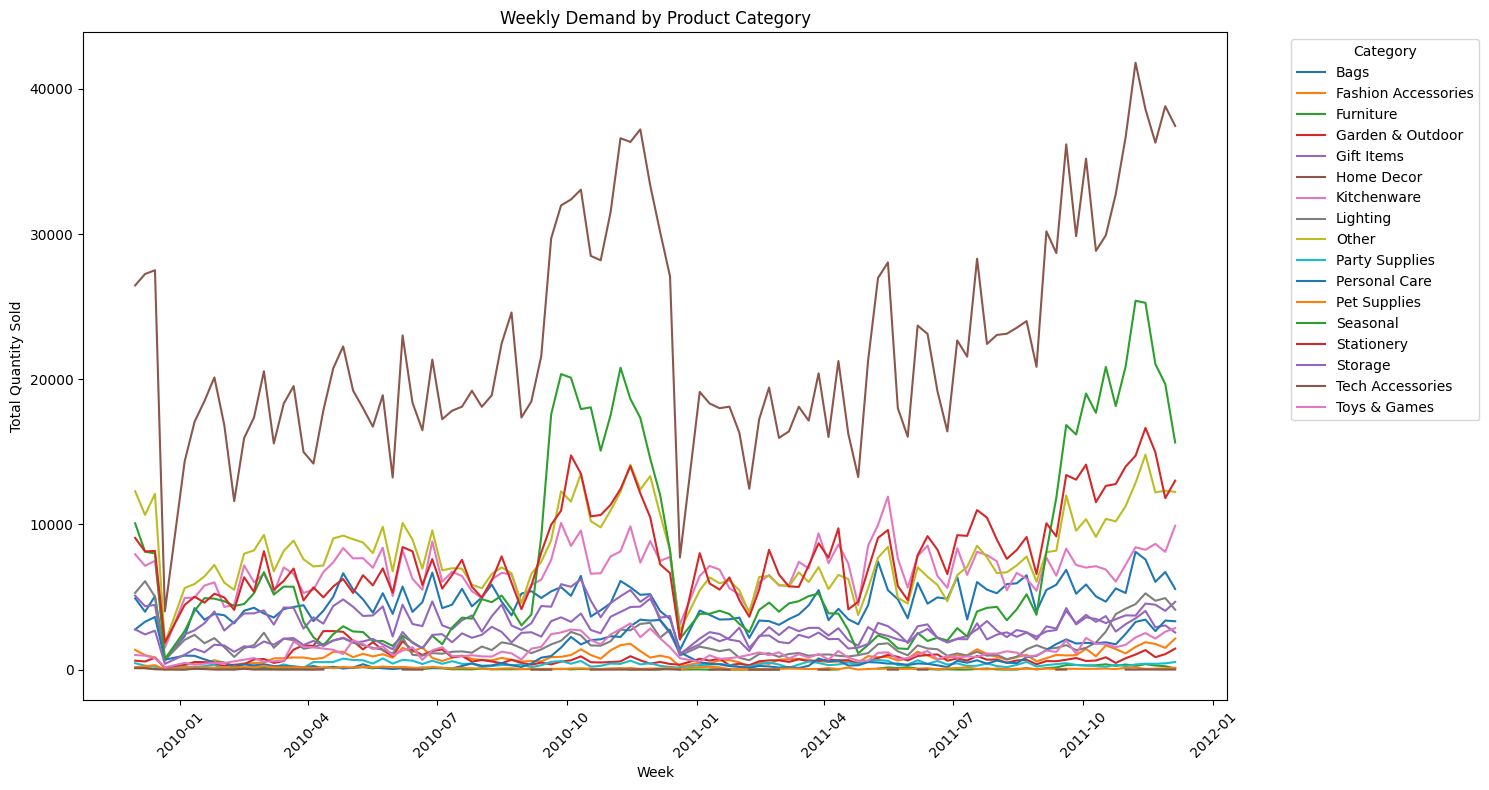

In [189]:
# Add a WeekStart column to track the date of the first day in the week:
data_df['WeekStart'] = data_df['InvoiceDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Group by week and category, summing quantity
weekly_category_sales = (
    data_df
    .groupby(['WeekStart', 'ProductCategory'])['Quantity']
    .sum()
    .reset_index()
)

# Pivot for plotting
pivot_df = weekly_category_sales.pivot(index='WeekStart', columns='ProductCategory', values='Quantity')


# Plot each category's weekly quantity
plt.figure(figsize=(15, 8))
for category in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[category], label=category)

plt.title('Weekly Demand by Product Category')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

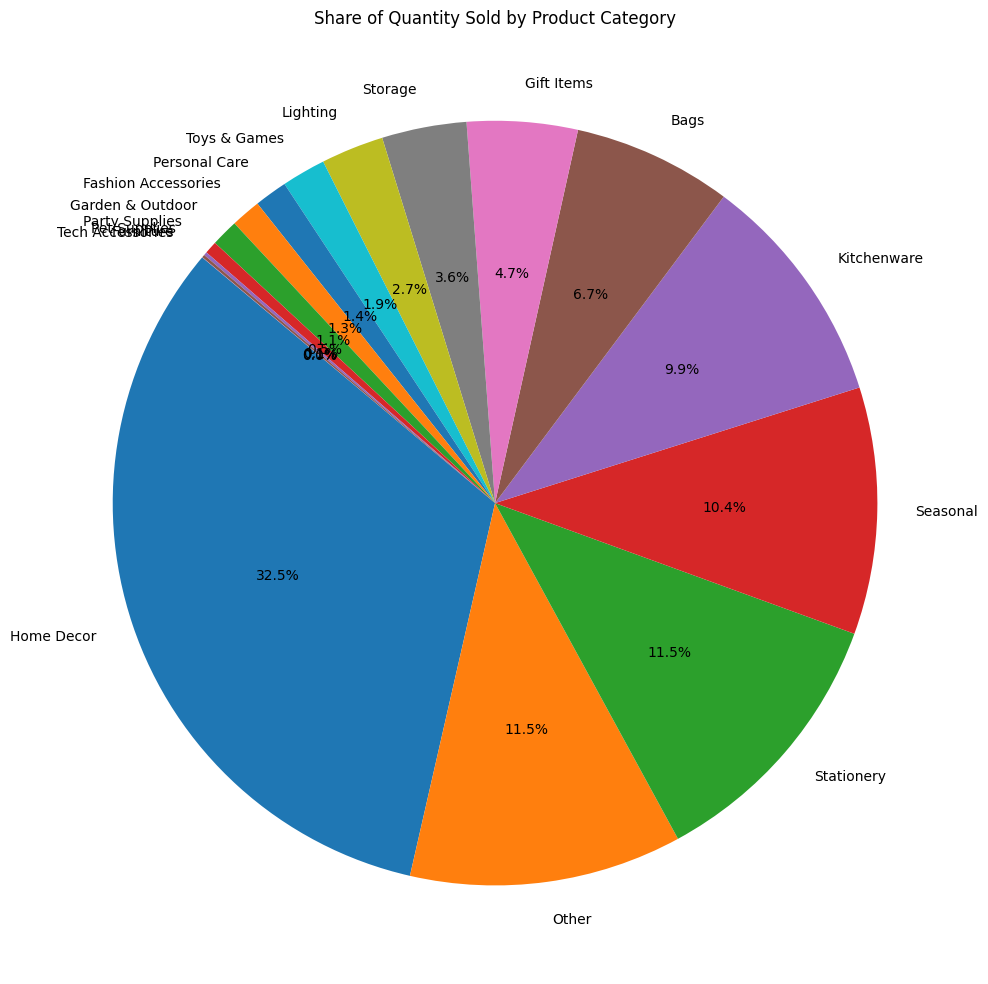

In [191]:
category_quantity = data_df.groupby('ProductCategory')['Quantity'].sum().sort_values(ascending=False)

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(category_quantity, labels=category_quantity.index, autopct='%1.1f%%', startangle=140)
plt.title('Share of Quantity Sold by Product Category')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.tight_layout()
plt.show()

In [192]:
data_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,isGuest,Month,Day,ProductCategory,WeekStart
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01,6.95,13085,United Kingdom,83.4,False,12,1,Seasonal,2009-11-30
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1,Lighting,2009-11-30
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01,6.75,13085,United Kingdom,81.0,False,12,1,Lighting,2009-11-30
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",31.0,2009-12-01,2.10,13085,United Kingdom,100.8,False,12,1,Home Decor,2009-11-30
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01,1.25,13085,United Kingdom,30.0,False,12,1,Gift Items,2009-11-30


In [195]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression

In [207]:
# # Group by WeekStart and ProductCategory to get weekly revenue per category
# weekly_data = data_df.groupby(['WeekStart', 'ProductCategory']).agg(
#     Weekly_Revenue=('Revenue', 'sum'),
#     Avg_UnitPrice=('UnitPrice', 'mean'),
#     Total_Quantity=('Quantity', 'sum'),
#     Unique_Customers=('CustomerID', 'nunique'),
#     Guest_Ratio=('isGuest', 'mean')
# ).reset_index()

# # Add date-based features
# weekly_data['Year'] = pd.to_datetime(weekly_data['WeekStart']).dt.year
# weekly_data['Month'] = pd.to_datetime(weekly_data['WeekStart']).dt.month
# weekly_data['WeekOfYear'] = pd.to_datetime(weekly_data['WeekStart']).dt.isocalendar().week

# # Add lagged features (previous week's revenue)
# weekly_data = weekly_data.sort_values(['ProductCategory', 'WeekStart'])
# weekly_data['Prev_Week_Revenue'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].shift(1)
# weekly_data['Prev_2_Week_Revenue'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].shift(2)

# # Add rolling averages
# weekly_data['Rolling_4W_Avg'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].transform(
#     lambda x: x.rolling(window=4, min_periods=1).mean().shift(1))

# # Add seasonal indicators
# weekly_data['IsSummer'] = ((weekly_data['Month'] >= 6) & (weekly_data['Month'] <= 8)).astype(int)
# weekly_data['IsHolidaySeason'] = ((weekly_data['Month'] >= 11) | (weekly_data['Month'] <= 1)).astype(int)

# # Remove rows with NaN values (first weeks of each category where lag features are missing)
# weekly_data = weekly_data.dropna()

# # Cap values at 90th percentile => This capping is important to handle sneaky outliers
# # It increased performance dramatically!
# cap_value = weekly_data['Weekly_Revenue'].quantile(0.90)
# weekly_data['Weekly_Revenue'] = weekly_data['Weekly_Revenue'].clip(upper=cap_value)

# # Step 3: Prepare data for modeling
# # Features are all rows without the Weekly_Revenue (our target) & WeekStart
# X = weekly_data.drop(['WeekStart', 'Weekly_Revenue'], axis=1)
# y = weekly_data['Weekly_Revenue']

# # Convert categorical variables
# categorical_cols = ['ProductCategory']
# numerical_cols = [col for col in X.columns if col not in categorical_cols]

# # Use a column transformer for preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
#     ])

# # We'll use TimeSeriesSplit for proper time-based validation
# tscv = TimeSeriesSplit(n_splits=5)
# splits = list(tscv.split(X))
# train_idx, test_idx = splits[-1]  # Use the last fold

# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

<ipython-input-207-69062a19213c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data['Weekly_Revenue'] = weekly_data['Weekly_Revenue'].clip(upper=cap_value)


In [232]:
# Aggregate data without quantity or customer features
weekly_data = data_df.groupby(['WeekStart', 'ProductCategory']).agg(
    Weekly_Revenue=('Revenue', 'sum'),
    Avg_UnitPrice=('UnitPrice', 'mean')  # Keeping price as a category characteristic
).reset_index()

# Focus on time-based features
weekly_data['Year'] = pd.to_datetime(weekly_data['WeekStart']).dt.year
weekly_data['Month'] = pd.to_datetime(weekly_data['WeekStart']).dt.month
weekly_data['WeekOfYear'] = pd.to_datetime(weekly_data['WeekStart']).dt.isocalendar().week

# Add seasonal indicators
weekly_data['IsSummer'] = ((weekly_data['Month'] >= 6) & (weekly_data['Month'] <= 8)).astype(int)
weekly_data['IsHolidaySeason'] = ((weekly_data['Month'] >= 11) | (weekly_data['Month'] <= 1)).astype(int)
weekly_data['IsSpring'] = ((weekly_data['Month'] >= 3) & (weekly_data['Month'] <= 5)).astype(int)
weekly_data['IsFall'] = ((weekly_data['Month'] >= 9) & (weekly_data['Month'] <= 10)).astype(int)

# Add lagged features (previous weeks' revenue)
weekly_data = weekly_data.sort_values(['ProductCategory', 'WeekStart'])
weekly_data['Prev_Week_Revenue'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].shift(1)
weekly_data['Prev_2_Week_Revenue'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].shift(2)
weekly_data['Prev_3_Week_Revenue'] = weekly_data.groupby('ProductCategory')['Weekly_Revenue'].shift(3)

# Remove rows with NaN values (first weeks of each category where lag features are missing)
weekly_data = weekly_data.dropna()

# Cap values at 90th percentile => This capping is important to handle sneaky outliers
# It increased performance dramatically!
cap_value = weekly_data['Weekly_Revenue'].quantile(0.90)
weekly_data['Weekly_Revenue'] = weekly_data['Weekly_Revenue'].clip(upper=cap_value)

# Step 3: Prepare data for modeling
# Define X (features)
X = weekly_data[[
    # Category
    'ProductCategory',
    # Time features
    'Year',
    'Month',
    'WeekOfYear',
    # Seasonal indicators
    'IsSummer',
    'IsHolidaySeason',
    'IsSpring',
    'IsFall',
    # Historical patterns
    'Prev_Week_Revenue',
    'Prev_2_Week_Revenue',
    'Prev_3_Week_Revenue',
]]

# Define y (target) - using log transform to handle outliers
y = weekly_data['Weekly_Revenue']

# Convert categorical variables
categorical_cols = ['ProductCategory']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Use a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# We'll use TimeSeriesSplit for proper time-based validation
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[-1]  # Use the last fold

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [233]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    return mae, rmse, r2

In [234]:
# Store results
results = []

# Train multiple models
# 1. Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")
results.append(('Linear Regression', *lr_metrics))

# 2. Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")
results.append(('Random Forest', *rf_metrics))

# 3. XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
xgb_metrics = evaluate_model(y_test, y_pred_xgb, "XGBoost")
results.append(('XGBoost', *xgb_metrics))

# Visualize model performance
models_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2'])
print("\nModel performance comparison:")
print(models_df)

Linear Regression performance:
MAE: 4055.80
RMSE: 4879.81
R²: -0.0540
Random Forest performance:
MAE: 1562.87
RMSE: 2597.07
R²: 0.7015
XGBoost performance:
MAE: 1483.00
RMSE: 2434.29
R²: 0.7377

Model performance comparison:
               Model          MAE         RMSE        R2
0  Linear Regression  4055.797488  4879.809083 -0.054020
1      Random Forest  1562.874770  2597.070626  0.701454
2            XGBoost  1482.997743  2434.291918  0.737706


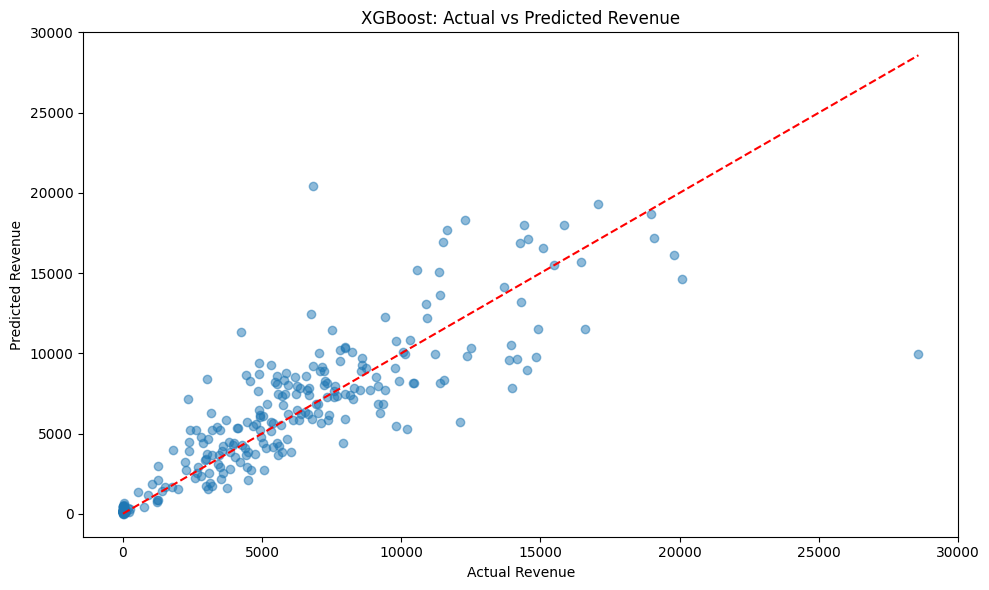

In [235]:
# Visualize predictions vs actuals for the best model (assuming XGBoost)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('XGBoost: Actual vs Predicted Revenue')
plt.tight_layout()
plt.show()

In [236]:
weekly_data.head()

,WeekStart,ProductCategory,Weekly_Revenue,Avg_UnitPrice,Year,Month,WeekOfYear,IsSummer,IsHolidaySeason,IsSpring,IsFall,Prev_Week_Revenue,Prev_2_Week_Revenue,Prev_3_Week_Revenue
51,2009-12-21,Bags,1805.94,3.970123,2009,12,52,0,1,0,0,13521.98,11287.01,14907.32
68,2010-01-04,Bags,11708.85,1.991961,2010,1,1,0,1,0,0,1805.94,13521.98,11287.01
85,2010-01-11,Bags,12853.27,2.313514,2010,1,2,0,1,0,0,11708.85,1805.94,13521.98
102,2010-01-18,Bags,8079.82,2.222830,2010,1,3,0,1,0,0,12853.27,11708.85,1805.94
119,2010-01-25,Bags,10857.23,2.122661,2010,1,4,0,1,0,0,8079.82,12853.27,11708.85


In [242]:
# One sample row for testing (dictionary format)
new_data = pd.DataFrame([{
    'ProductCategory': 'Bags',
    'Year': 2010,
    'Month': 1,
    'WeekOfYear': 4,
    'Prev_Week_Revenue': 8079.82	,
    'Prev_2_Week_Revenue': 12853.27,
    'Prev_3_Week_Revenue': 11708.85	,
    'IsSummer': 0,
    'IsHolidaySeason': 1,
    'IsSpring': 0,
    'IsFall': 0,
}])

In [243]:
print(rf_pipeline.predict(new_data))
print(xgb_pipeline.predict(new_data))

[10335.4232]
[10698.904]


##Hyperparameter tuning

In [244]:
# Import necessary libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import randint, uniform

# Define custom scoring metrics for evaluating models during tuning
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(rmse, greater_is_better=False),
    'r2': make_scorer(r2_score, greater_is_better=True)
}

In [245]:
# 1. RANDOM FOREST HYPERPARAMETER TUNING
# Define the parameter grid for Random Forest
rf_param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

# Create GridSearchCV for Random Forest
rf_grid = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

# Fit GridSearchCV
print("Starting Random Forest GridSearchCV...")
rf_grid.fit(X, y)  # Using full dataset for tuning

# Print best parameters and score
print(f"Best Random Forest Parameters: {rf_grid.best_params_}")
print(f"Best MAE Score: {-rf_grid.best_score_:.2f}")

# Evaluate the best Random Forest model
best_rf = rf_grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
rf_best_metrics = evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest")

Starting Random Forest GridSearchCV...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
278 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, 

Best Random Forest Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Best MAE Score: 2808.37
Tuned Random Forest performance:
MAE: 1139.04
RMSE: 1913.45
R²: 0.8379


In [246]:
# 2. XGBOOST HYPERPARAMETER TUNING
# Define parameter distributions for RandomizedSearchCV
xgb_param_dist = {
    'regressor__n_estimators': randint(50, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4),
    'regressor__min_child_weight': randint(1, 10),
    'regressor__gamma': uniform(0, 1)
}

# Create RandomizedSearchCV for XGBoost
xgb_random = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=25,  # Number of parameter settings sampled
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error',
    random_state=42,
    return_train_score=True
)

# Fit RandomizedSearchCV
print("\nStarting XGBoost RandomizedSearchCV...")
xgb_random.fit(X, y)  # Using full dataset for tuning

# Print best parameters and score
print(f"Best XGBoost Parameters: {xgb_random.best_params_}")
print(f"Best MAE Score: {-xgb_random.best_score_:.2f}")

# Evaluate the best XGBoost model
best_xgb = xgb_random.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
xgb_best_metrics = evaluate_model(y_test, y_pred_best_xgb, "Tuned XGBoost")


Starting XGBoost RandomizedSearchCV...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost Parameters: {'regressor__colsample_bytree': np.float64(0.6180909155642152), 'regressor__gamma': np.float64(0.32533033076326434), 'regressor__learning_rate': np.float64(0.1266031869068446), 'regressor__max_depth': 4, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 73, 'regressor__subsample': np.float64(0.7427013306774357)}
Best MAE Score: 2865.00
Tuned XGBoost performance:
MAE: 1125.03
RMSE: 1763.07
R²: 0.8624


In [247]:
# 3. LINEAR REGRESSION (Ridge/Lasso regularization tuning)
# Define parameter grid for Ridge/Lasso regularization
from sklearn.linear_model import Ridge, Lasso

# Ridge regression
ridge_param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

ridge_grid = GridSearchCV(
    ridge_pipeline,
    param_grid=ridge_param_grid,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

print("\nStarting Ridge Regression GridSearchCV...")
ridge_grid.fit(X, y)
print(f"Best Ridge Parameters: {ridge_grid.best_params_}")
print(f"Best MAE Score: {-ridge_grid.best_score_:.2f}")

# Evaluate the best Ridge model
best_ridge = ridge_grid.best_estimator_
y_pred_best_ridge = best_ridge.predict(X_test)
ridge_best_metrics = evaluate_model(y_test, y_pred_best_ridge, "Tuned Ridge Regression")


Starting Ridge Regression GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Ridge Parameters: {'regressor__alpha': 100.0}
Best MAE Score: 5129.57
Tuned Ridge Regression performance:
MAE: 2291.89
RMSE: 3157.61
R²: 0.5587


In [248]:
# 4. COMPARE ALL TUNED MODELS
# Store final results
final_results = [
    ('Linear Regression', *lr_metrics),
    ('Tuned Ridge Regression', *ridge_best_metrics),
    ('Random Forest', *rf_metrics),
    ('Tuned Random Forest', *rf_best_metrics),
    ('XGBoost', *xgb_metrics),
    ('Tuned XGBoost', *xgb_best_metrics)
]

# Visualize final model performance
final_models_df = pd.DataFrame(final_results, columns=['Model', 'MAE', 'RMSE', 'R2'])
print("\nFinal model performance comparison:")
print(final_models_df)

# Sort models by MAE (lower is better)
final_models_df_sorted = final_models_df.sort_values('MAE')
print("\nModels ranked by MAE (lower is better):")
print(final_models_df_sorted)


Final model performance comparison:
                    Model          MAE         RMSE        R2
0       Linear Regression  4055.797488  4879.809083 -0.054020
1  Tuned Ridge Regression  2291.886264  3157.610232  0.558673
2           Random Forest  1562.874770  2597.070626  0.701454
3     Tuned Random Forest  1139.037741  1913.449442  0.837939
4                 XGBoost  1482.997743  2434.291918  0.737706
5           Tuned XGBoost  1125.027267  1763.070859  0.862411

Models ranked by MAE (lower is better):
                    Model          MAE         RMSE        R2
5           Tuned XGBoost  1125.027267  1763.070859  0.862411
3     Tuned Random Forest  1139.037741  1913.449442  0.837939
4                 XGBoost  1482.997743  2434.291918  0.737706
2           Random Forest  1562.874770  2597.070626  0.701454
1  Tuned Ridge Regression  2291.886264  3157.610232  0.558673
0       Linear Regression  4055.797488  4879.809083 -0.054020


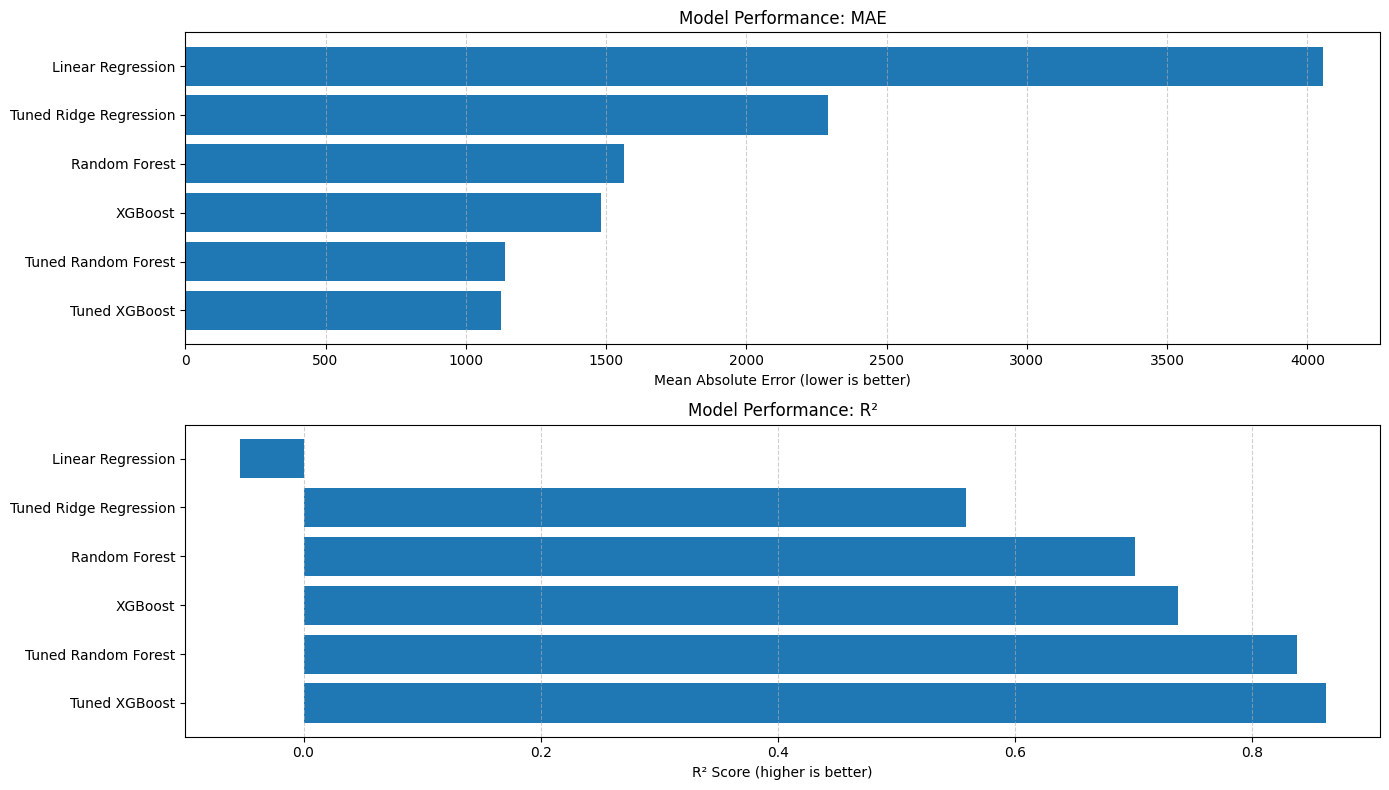

In [249]:
# Visualize the results
plt.figure(figsize=(14, 8))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.barh(final_models_df_sorted['Model'], final_models_df_sorted['MAE'])
plt.xlabel('Mean Absolute Error (lower is better)')
plt.title('Model Performance: MAE')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Plot R2 scores
plt.subplot(2, 1, 2)
plt.barh(final_models_df_sorted['Model'], final_models_df_sorted['R2'])
plt.xlabel('R² Score (higher is better)')
plt.title('Model Performance: R²')
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [251]:
best_model = best_xgb

Saving Models

In [252]:
# Part 1: Save all models (original and tuned)
import joblib
import os

# Create a directory for the models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save original models
print("Saving original models...")
joblib.dump(lr_pipeline, 'models/linear_regression.pkl')
joblib.dump(rf_pipeline, 'models/random_forest.pkl')
joblib.dump(xgb_pipeline, 'models/xgboost.pkl')

# Save tuned models
print("Saving tuned models...")
joblib.dump(best_ridge, 'models/tuned_ridge.pkl')
joblib.dump(best_rf, 'models/tuned_random_forest.pkl')
joblib.dump(best_xgb, 'models/tuned_xgboost.pkl')

# Save the best overall model separately
print("Saving best overall model...")
joblib.dump(best_model, 'models/best_model.pkl')

# Save the best overall model separately
print("Saving best overall model...")
joblib.dump(best_model, 'models/best_model.pkl')

print("All models saved to 'models/' directory")

# Zip the models directory for easy download
import shutil
print("Creating zip archive of models...")
shutil.make_archive('revenue_prediction_models', 'zip', 'models')
print("Models archive created: revenue_prediction_models.zip")

Saving original models...
Saving tuned models...
Saving best overall model...
Saving best overall model...
All models saved to 'models/' directory
Creating zip archive of models...
Models archive created: revenue_prediction_models.zip
